In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import self_attention_cv
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd

import torch
device = torch.device('cpu')


#JAX
import jax
import jax.numpy as jnp

from jax_cosmo.scipy import interpolate as jax_interpolate

# Probably should specify in the outer script, not the inner modules
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)

# for Matern kernel with Modified Bessel of the 2nd kind (tfp>=0.17.0-dev20220322)
import tensorflow_probability as tfp


#CPUs parallelization
import multiprocessing
max_thread_numbers=multiprocessing.cpu_count()
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(max_thread_numbers)

fig = plt.figure()
#plt.plot()
mpl.style.use('default')
rcParams = {
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "lightgray",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black",
    "legend.facecolor":'lightgray',
    "legend.edgecolor":'black',
    'axes.titlecolor': 'white'}

def set_style():
    global fig
    mpl.style.use('default')
    plt.rcParams.update(rcParams)
    fig.patch.set_alpha(0)

FS = 18 # fontsize


import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

def to_date(time_array,offset_date='2000-01-01T00:00:00'):
    return np.array([pd.Timedelta(x,'days').round('d')+pd.Timestamp(offset_date) for x in time_array])

/Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /Users/egorssed/miniforge3/envs/Fermilab_torch_sum/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


<Figure size 432x288 with 0 Axes>

In [3]:
import os

folder = '../data/Kepler/'
names = np.array(os.listdir(folder))
names= np.sort(names)
#delete '.DS_Store'
names = np.delete(names,np.where(names=='.DS_Store')[0])

In [4]:
dfs = []
for i,name in enumerate(names):
    df = pd.read_csv(folder+'/'+name,index_col=0)
    dfs+=[df]

# Corrections

## Gap in the end

In [5]:
for index,_ in enumerate(names):
    df = dfs[index]
    dfs[index] = df[df['time']<1581.6]

# Start gap and end divergence in 8946433

In [6]:
index = 8
df = dfs[index]
dfs[index] = df[df['time']>1352.85].iloc[:-4]

## Check

In [7]:
for index,_ in enumerate(names):
    dfs[index].reset_index(inplace=True,drop=True)

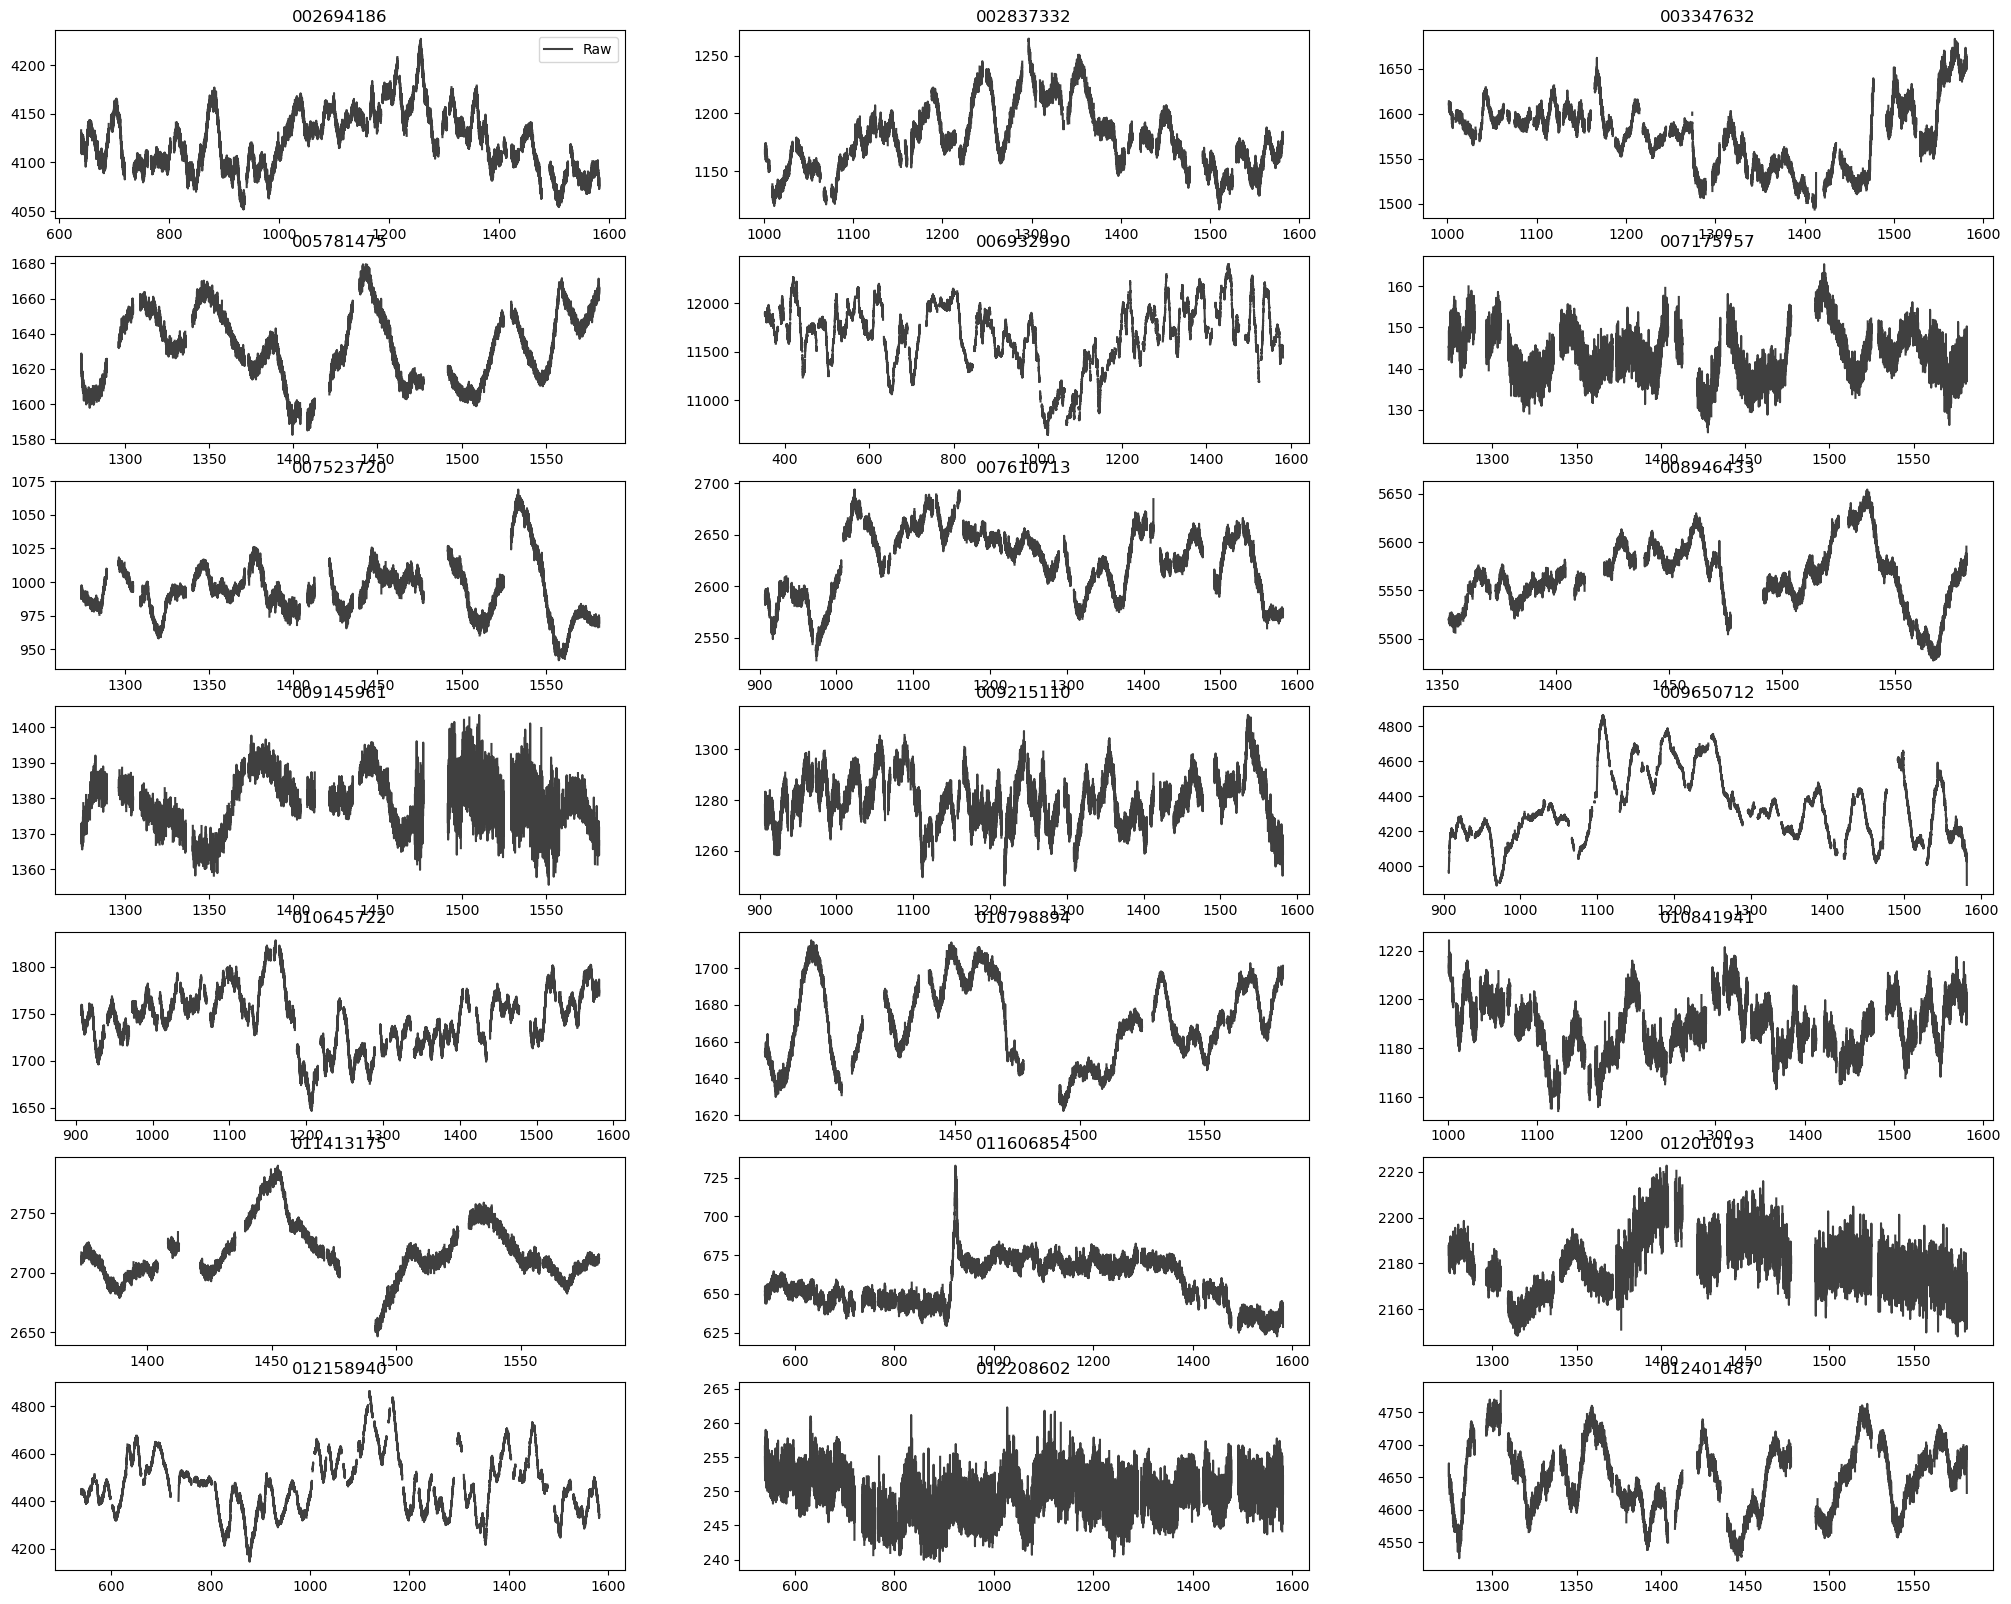

In [8]:
from copy import deepcopy
fig,ax = plt.subplots(7,3,figsize=(25,20))

for i in range(7):
    for j in range(3):
        index = 3*i+j
        df = dfs[index]

        time = df['time']
        light = df['light']
        mask = ~np.isnan(light)

        trend = scipy.stats.linregress(time[mask]-time[mask][0],light[mask])

        ax[i,j].plot(time,light-trend[0]*time,color='k',alpha=0.75,label='Raw')


        ax[i,j].set_title(names[index][:-4])
ax[0,0].legend()

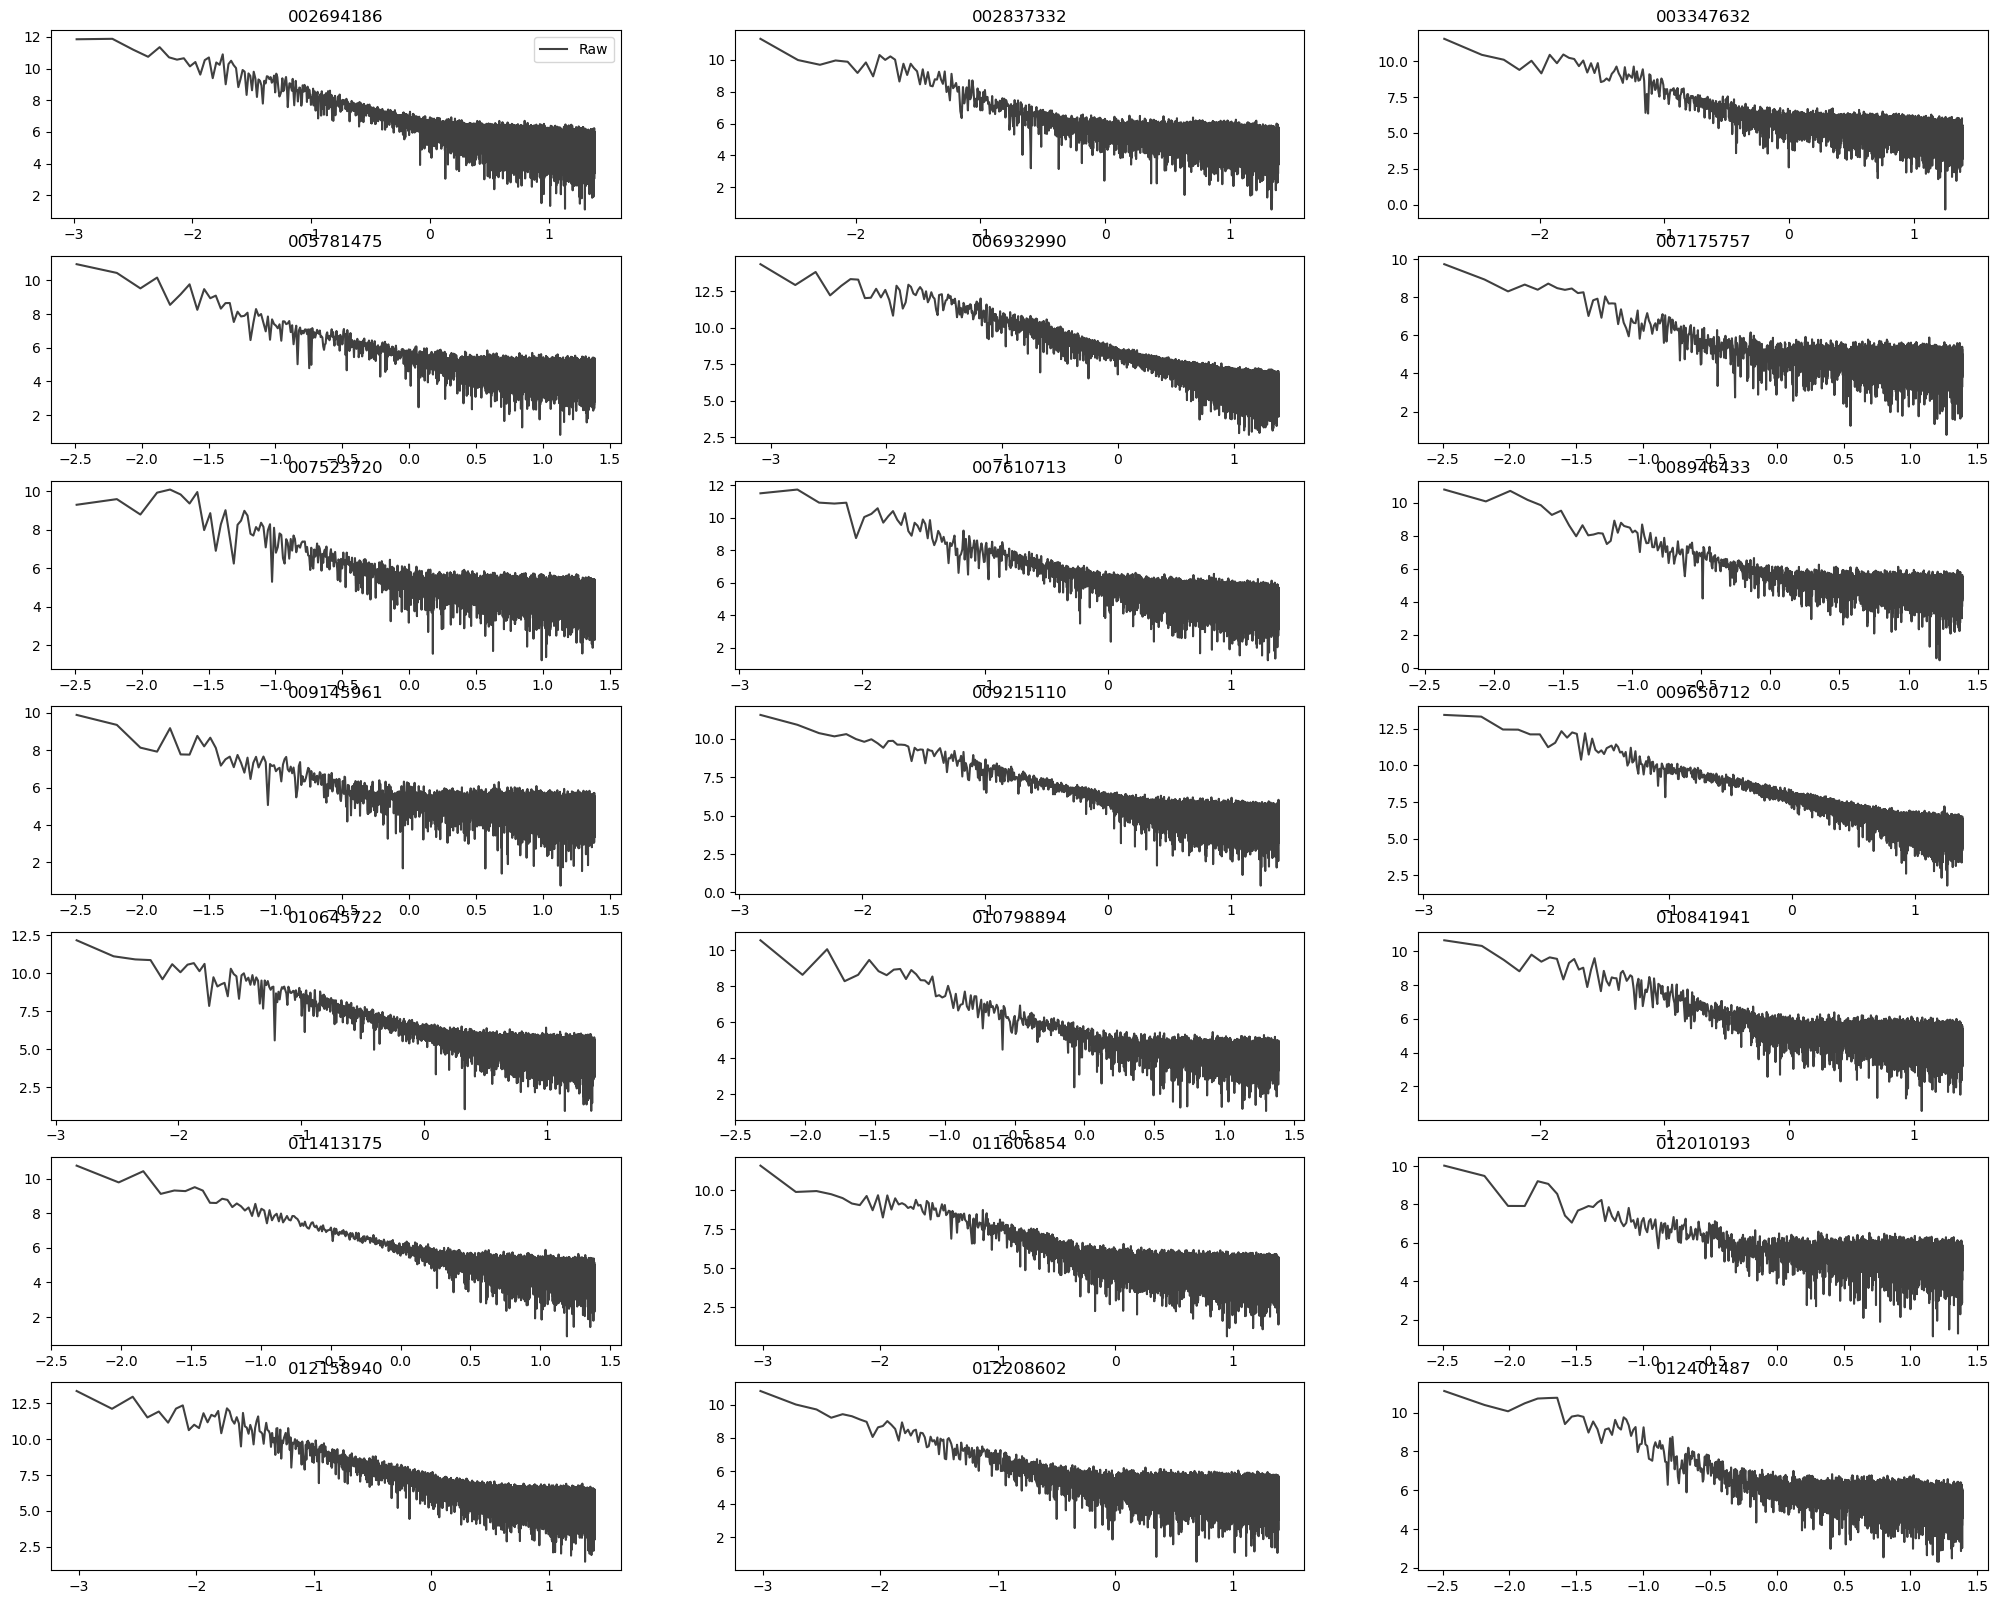

In [9]:
from copy import deepcopy
fig,ax = plt.subplots(7,3,figsize=(25,20))

for i in range(7):
    for j in range(3):
        index = 3*i+j
        df = dfs[index]

        time = df['time']
        light = df['light']
        mask = ~np.isnan(light)
        time_step = np.median(np.diff(df.time))
        t = np.arange(time.min(),time.max(),time_step)
        spline = np.interp(t,time[mask],light[mask])

        freq = np.fft.rfftfreq(len(t),time_step)
        spec = np.abs(np.fft.rfft(spline))**2

        ax[i,j].plot(np.log10(freq[1:]),np.log10(spec[1:]),color='k',alpha=0.75,label='Raw')


        ax[i,j].set_title(names[index][:-4])
ax[0,0].legend()

# MCMC model fitting

In [10]:
from functools import partial
class Quasar_Reverberation():

    def Reverberation_kernel(self,x):
        eps = 1e-8

        non_zero = (x>8e-10) & (x<100)

        x = jnp.clip(x,8e-10,77)
        return non_zero*jnp.power(x,7/4)/(2*jnp.cosh(jnp.power(x,3/4))-2+eps)

    def _log_double_powerlaw(self,log_freq,log_amplitude,low_freq_power,softenting,softening_power,damping_power):

        damped_factor = damping_power*jnp.log10(1+jnp.power(10,softenting+softening_power*log_freq))

        return log_amplitude+ low_freq_power * log_freq + damped_factor

    def _log_exp_powerlaw(self,log_freq,log_amplitude,log_sigma,power):

        return log_amplitude - jnp.power(10,log_freq*power + log_sigma)


    def Reverberation_power_spectrum(self,freq):

        # fit of the reverberation kernel spectrum in the Fourier space
        log_amplitude_cos,log_sigma_cos,power_cos,log_amplitude,low_freq_power,softenting,softening_power,damping_power = \
            np.array([-1.86166978,  2.21309937,  1.77202243, -0.45252364,  0.95982081, 5.98492459,  4.028355  , -0.548786  ])

        log_freq = jnp.log10(freq)

        cosine_log_spec = self._log_exp_powerlaw(log_freq,log_amplitude_cos,log_sigma_cos,power_cos)
        sine_log_spec = self._log_double_powerlaw(log_freq,log_amplitude,low_freq_power,softenting,softening_power,damping_power)

        return jnp.power(10,2*cosine_log_spec) + jnp.power(10,2*sine_log_spec)

class Convolved_Matern_Walk():

    def __init__(self):

        self.Reverberation_class = Quasar_Reverberation()

    def Sotened_powerlaw(self,freq,Correlation_time,order_nu):

        return jnp.power(1+(2*np.pi*freq*Correlation_time)**2,-order_nu-0.5)

    def Convolved_Matern_spectrum(self,frequencies,Correlation_time,order_nu,Reverberation_time,Variance=1):

        accretion_spectrum = self.Sotened_powerlaw(frequencies,Correlation_time,order_nu)
        #accretion_spectrum = self.Matern_spectrum(frequencies,Correlation_time,order_nu)
        transfer_spectrum = self.Reverberation_class.Reverberation_power_spectrum(frequencies*Reverberation_time)

        flux_spectrum = accretion_spectrum*transfer_spectrum
        #flux_spectrum = jnp.append(np.zeros(1),accretion_spectrum*transfer_spectrum)
        norm = 2*(flux_spectrum[1:]).sum()
        flux_spectrum/=norm

        return Variance*flux_spectrum

    def Double_DRW_spectrum(self,frequencies,Correlation_time,Reverberation_time,Amplitude=1):

        accretion_spectrum = self.Sotened_powerlaw(frequencies,Correlation_time,order_nu=0.5)
        #accretion_spectrum = self.Matern_spectrum(frequencies,Correlation_time,order_nu)
        transfer_spectrum = self.Sotened_powerlaw(frequencies,Reverberation_time,order_nu=0.5)

        flux_spectrum = accretion_spectrum*transfer_spectrum

        return Amplitude*flux_spectrum
Quasar = Convolved_Matern_Walk()

In [11]:
class PSRESP_class():

    def __init__(self,df,time_step=29.4/60/24,num_freqs = 25,MCMC_sampling_number = 500,remove_trend=True):

        self.remove_trend = remove_trend

        self.time_step = time_step
        self.time = np.arange(df['time'].min(),df['time'].max()+time_step,time_step)
        if (len(self.time) % 2):
            self.time = self.time[:-1]
        self.time -= self.time[0]

        light = np.zeros_like(self.time)*np.nan
        idx = ((df['time'].values - df['time'].values[0]) //time_step).astype(int)
        light[idx] = df['light'].values

        self.obs_light = light
        self.mask = ~np.isnan(light)

        self.dft_freqs = np.fft.rfftfreq(len(self.time),time_step)
        self.freqs = np.logspace(np.log10(self.dft_freqs[1]),np.log10(self.dft_freqs[-1]),num_freqs)

        self.data_spectrum = np.array(self.power_spec(self.obs_light))


        self.Quasar = Convolved_Matern_Walk()
        self.MCMC_sampling_number = MCMC_sampling_number
        self.dft_freqs_long = np.fft.rfftfreq(MCMC_sampling_number*len(self.time),self.time_step)
        self.fourier_noise = (np.random.default_rng(42).normal(size=len(self.dft_freqs_long)*2).reshape(-1,2)*np.array([1+0j,0+1j])).sum(1)

        self.sim_time = tuple(self.time)



    @partial(jax.jit,static_argnums=(0,))
    def power_spec(self,light):

        light  = light.at[~self.mask].set(jnp.interp(self.time[~self.mask],self.time[self.mask],light[self.mask]))
        if self.remove_trend:
            slope = (jnp.mean(self.time*light) - np.mean(self.time)*jnp.mean(light))/(np.mean(self.time**2) - np.mean(self.time)**2)
            light -= self.time*slope
        light-=light.mean()

        cosine = jnp.sum(light[:,None]*np.cos(2*np.pi*self.freqs[None,:]*self.time[:,None]),axis=0)
        sine = jnp.sum(light[:,None]*np.sin(2*np.pi*self.freqs[None,:]*self.time[:,None]),axis=0)

        # norm ortho
        return (cosine**2 + sine**2)/ len(self.time)

    def simulate_long_curve(self,Correlation_time,Reverberation_time,Amplitude,Noise_power):

        #noise_power = Noise_variance/(2*(len(self.dft_freqs_long)-1))
        spec_long = self.Quasar.Double_DRW_spectrum(self.dft_freqs_long,Correlation_time,Reverberation_time,Amplitude) + Noise_power
        #spec_long *= (self.dft_freqs_long!=0)
        fourier_long = jnp.sqrt(spec_long/2)*self.fourier_noise

        curve = jnp.fft.irfft(fourier_long,norm='ortho')
        return curve

    @partial(jax.jit,static_argnums=(0,))
    def NegLogLikelihood_analytic(self,args):

        Correlation_time,Reverberation_time,Amplitude,Noise_power = jnp.power(10,args)

        model_spec = self.Quasar.Double_DRW_spectrum(self.freqs,Correlation_time,Reverberation_time,Amplitude) + Noise_power

        nll = - jax.scipy.stats.expon.logpdf(self.data_spectrum,scale = model_spec,loc = np.zeros_like(self.freqs))

        return jnp.mean(nll)

    @partial(jax.jit,static_argnums=(0,))
    def NegLogLikelihood_analytic_DRW(self,args):

        Correlation_time,Amplitude,Noise_power = jnp.power(10,args)

        model_spec = self.Quasar.Double_DRW_spectrum(self.freqs,Correlation_time,0,Amplitude) + Noise_power

        nll = - jax.scipy.stats.expon.logpdf(self.data_spectrum,scale = model_spec,loc = np.zeros_like(self.freqs))

        return jnp.mean(nll)

In [12]:
def plot_fit(index,remove_trend = True):

    PSRESP = PSRESP_class(dfs[index],num_freqs=25,MCMC_sampling_number=500,remove_trend = remove_trend)
    self  = PSRESP

    Correlation_time, Reverberation_time, Amplitude, Noise_power = 10, 100, self.data_spectrum[0], self.data_spectrum[
        -1]


    p0 = np.log10([Correlation_time, Reverberation_time, Amplitude, Noise_power])

    bounds = scipy.optimize.Bounds(lb = np.log10(np.array([1/(2*np.pi*self.freqs[-1]),1/(2*np.pi*self.freqs[-1]),-np.inf,-np.inf])),
                               ub = np.log10(np.array([1/(self.freqs[0]),1/(self.freqs[0]),+np.inf,np.log10(self.data_spectrum[0])])),keep_feasible=True)

    res_CDRW = scipy.optimize.minimize(self.NegLogLikelihood_analytic, p0, jac=jax.grad(self.NegLogLikelihood_analytic),
                                       bounds=bounds,method='TNC')

    Correlation_time, Reverberation_time, Amplitude, Noise_power = np.power(10, res_CDRW.x)
    spec_CDRW = self.Quasar.Double_DRW_spectrum(self.dft_freqs, Correlation_time, Reverberation_time,
                                                Amplitude) + Noise_power
    bounds = scipy.optimize.Bounds(lb = np.log10(np.array([1/(2*np.pi*self.freqs[-1]),-np.inf,-np.inf])),
                               ub = np.log10(np.array([1/(self.freqs[0]),+np.inf,np.log10(self.data_spectrum[0])])),keep_feasible=True)

    res_DRW = scipy.optimize.minimize(self.NegLogLikelihood_analytic_DRW, p0[[0, 2, 3]],
                                      jac=jax.grad(self.NegLogLikelihood_analytic_DRW),
                                      bounds=bounds,method='TNC')

    Correlation_time, Amplitude, Noise_power = np.power(10, res_DRW.x)
    Reverberation_time = 0
    spec_DRW = self.Quasar.Double_DRW_spectrum(self.dft_freqs, Correlation_time, Reverberation_time,
                                               Amplitude) + Noise_power

    fig, ax = plt.subplots(figsize=(15, 7))

    lower,upper = np.log10(scipy.stats.expon.interval(0.68,loc=0,scale=1)) - np.log10(scipy.stats.expon.mean(loc=0,scale=1))
    ax.errorbar(np.log10(self.freqs),np.log10(self.data_spectrum),np.repeat([np.abs([lower,upper])],len(self.freqs),axis=0).T,color='k',zorder=1,
             label='Quasar KIC {}'.format(names[index][np.where([x=='0' for x in names[0]])[0][-1]:-4]),capsize=3)


    ax.vlines(np.log10(1/(2*np.pi*np.power(10,res_CDRW.x)[1])),np.log10(self.data_spectrum.min()),np.log10(self.data_spectrum.max()),label='CDRW '+r'$log(\rho)=$'+'{:.2f} '.format(res_CDRW.x[1]),color='C1',linestyle='--')
    ax.vlines(np.log10(1/(2*np.pi*np.power(10,res_CDRW.x)[0])),np.log10(self.data_spectrum.min()),np.log10(self.data_spectrum.max()),label='CDRW '+r'$log(\tau)=$'+'{:.2f} '.format(res_CDRW.x[0]),color='C1',linestyle='-.')

    ax.vlines(np.log10(1/(2*np.pi*np.power(10,res_DRW.x)[0])),np.log10(self.data_spectrum.min()),np.log10(self.data_spectrum.max()),label='DRW '+r'$log(\tau)=$'+'{:.2f} '.format(res_DRW.x[0]),color='C0',linestyle='--')


    ax.hlines(res_CDRW.x[-1],np.log10(self.freqs).min(),np.log10(self.freqs).max(),label='Noise',color='r')

    ax.plot(np.log10(self.dft_freqs),np.log10(spec_DRW),label='DRW '+'log'+r'$\mathcal{L}=$'+'{:.2f}'.format(-res_DRW.fun))
    ax.plot(np.log10(self.dft_freqs),np.log10(spec_CDRW),label='CDRW '+'log'+r'$\mathcal{L}=$'+'{:.2f}'.format(-res_CDRW.fun))
    ax.legend()


    ax.set_xlabel('log frequency [Hz]',fontsize=18)
    ax.set_ylabel('log Power',fontsize=18)
    ax.set_xlim(np.log10(self.freqs)[0]-0.2,np.log10(self.freqs)[-1]+0.2)
    plt.savefig('./Figures{}'.format('_detrend' if remove_trend else "")+'/{}'.format(names[index][:-4]))
    plt.show()

    print('CDRW: ', res_CDRW.fun, res_CDRW.x)
    print('DRW: ', res_DRW.fun, res_DRW.x)

In [13]:
names

array(['002694186.csv', '002837332.csv', '003347632.csv', '005781475.csv',
       '006932990.csv', '007175757.csv', '007523720.csv', '007610713.csv',
       '008946433.csv', '009145961.csv', '009215110.csv', '009650712.csv',
       '010645722.csv', '010798894.csv', '010841941.csv', '011413175.csv',
       '011606854.csv', '012010193.csv', '012158940.csv', '012208602.csv',
       '012401487.csv'], dtype='<U13')

In [14]:
index = 1
remove_trend = True

In [71]:
    PSRESP = PSRESP_class(dfs[index],num_freqs=25,MCMC_sampling_number=500,remove_trend = remove_trend)
    self  = PSRESP

    Correlation_time, Reverberation_time, Amplitude, Noise_power = 10, 100, self.data_spectrum[0], self.data_spectrum[
        -1]


    p0 = np.log10([Correlation_time, Reverberation_time, Amplitude, Noise_power])

    bounds = scipy.optimize.Bounds(lb = np.log10(np.array([1/(2*np.pi*self.freqs[-1]),1/(2*np.pi*self.freqs[-1]),0,0])),
                               ub = np.log10(np.array([1/(self.freqs[0]),1/(self.freqs[0]),+np.inf,self.data_spectrum[0]])),keep_feasible=True)

    res_CDRW = scipy.optimize.minimize(self.NegLogLikelihood_analytic, p0, jac=jax.grad(self.NegLogLikelihood_analytic),
                                       bounds=bounds,method='TNC')

    Correlation_time, Reverberation_time, Amplitude, Noise_power = np.power(10, res_CDRW.x)
    spec_CDRW = self.Quasar.Double_DRW_spectrum(self.dft_freqs, Correlation_time, Reverberation_time,
                                                Amplitude) + Noise_power

    bounds = scipy.optimize.Bounds(lb = np.log10(np.array([1/(2*np.pi*self.freqs[-1]),0,0])),
                               ub = np.log10(np.array([1/(self.freqs[0]),+np.inf,self.data_spectrum[0]])),keep_feasible=True)

    res_DRW = scipy.optimize.minimize(self.NegLogLikelihood_analytic_DRW, p0[[0, 2, 3]],
                                      jac=jax.grad(self.NegLogLikelihood_analytic_DRW),
                                      bounds=bounds,method='TNC')

    Correlation_time, Amplitude, Noise_power = np.power(10, res_DRW.x)
    Reverberation_time = 0
    spec_DRW = self.Quasar.Double_DRW_spectrum(self.dft_freqs, Correlation_time, Reverberation_time,
                                               Amplitude) + Noise_power

In [21]:
Correlation_time, Reverberation_time, Amplitude, Noise_power = np.power(10, res_CDRW.x)

In [39]:
dft_freqs = np.fft.rfftfreq(2000*len(self.time),self.time_step)

In [40]:
spec_long = self.Quasar.Double_DRW_spectrum(dft_freqs,Correlation_time,Reverberation_time,Amplitude) + Noise_power
fourier_noise = (np.random.default_rng(42).normal(size=len(dft_freqs)*2).reshape(-1,2)*np.array([1+0j,0+1j])).sum(1)
fourier_long = jnp.sqrt(spec_long/2)*fourier_noise

long_curve = jnp.fft.irfft(fourier_long,norm='ortho')

In [42]:
spectra = jax.vmap(self.power_spec)(long_curve.reshape(2000,-1))

In [48]:
quantiles = np.quantile(np.log10(spectra),[0.5-0.34,0.5,0.5+0.34],axis=0)

In [50]:
lower = quantiles[1]-quantiles[0]
upper= quantiles[2] - quantiles[1]

In [90]:
err = (lower+upper)/2

Correlation_time, Reverberation_time, Amplitude, Noise_power = np.power(10, res_CDRW.x)
spec_CDRW_discr = self.Quasar.Double_DRW_spectrum(self.freqs, Correlation_time, Reverberation_time,
                                                Amplitude) + Noise_power

Correlation_time, Amplitude, Noise_power = np.power(10, res_DRW.x)
Reverberation_time = 0
spec_DRW_discr = self.Quasar.Double_DRW_spectrum(self.freqs, Correlation_time, Reverberation_time,
                                               Amplitude) + Noise_power

In [91]:
dev = (np.log10(self.data_spectrum) - np.log10(spec_CDRW_discr))
chi2_CDRW = np.mean((dev/((dev>0)*lower + (dev<0)*upper))**2)

In [92]:
chi2_CDRW

0.9204032488089462

In [93]:
dev = (np.log10(self.data_spectrum) - np.log10(spec_DRW_discr))
chi2_DRW = np.mean((dev/((dev>0)*lower + (dev<0)*upper))**2)

In [94]:
chi2_DRW

1.783820320516489

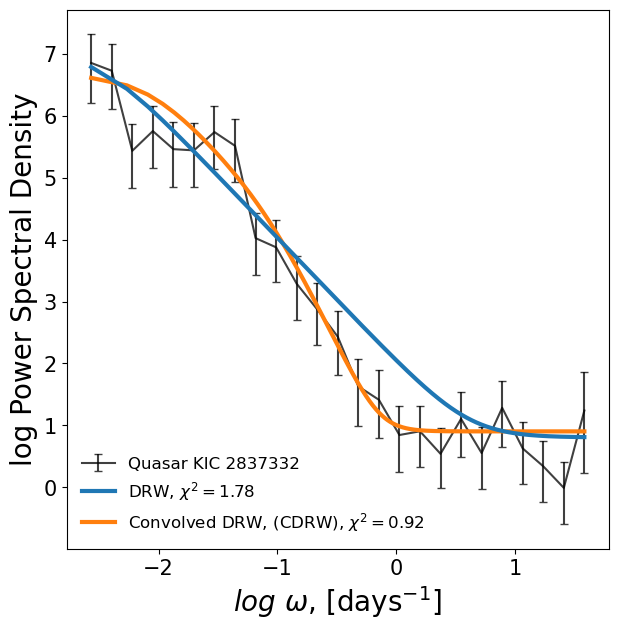

In [97]:
fig,ax = plt.subplots(figsize=(7,7))


h1 = plt.errorbar(np.log10(self.freqs) - np.log10(2/np.pi),np.log10(self.data_spectrum),[lower,upper],color='k',capsize=3,alpha=0.75,label='Quasar KIC 2837332',zorder=0)


h3,= plt.plot(np.log10(self.dft_freqs) - np.log10(2/np.pi),np.log10(spec_CDRW),linewidth=3,label='Convolved DRW, (CDRW), '+r'$\chi^2=$'+'{:.2f}'.format(chi2_CDRW),color='C1')
h2, = plt.plot(np.log10(self.dft_freqs) - np.log10(2/np.pi),np.log10(spec_DRW),linewidth=3,label='DRW, '+r'$\chi^2=$'+'{:.2f}'.format(chi2_DRW),color='C0')


labels = ['Quasar KIC 2837332','Convolved DRW (CDRW), '+r'$\chi^2=$'+'{:.2f}'.format(chi2_CDRW),
                       'Damped Random Walk (DRW), '+r'$\chi^2=$'+'{:.2f}'.format(chi2_CDRW)]

plt.xlabel(r'$log \ \omega$'+', [days'+r'$^{-1}$'+']',fontsize=20)
plt.ylabel('log Power Spectral Density',fontsize=20)
plt.legend(handles = [h1,h2,h3],loc='lower left',fontsize=12,framealpha=0)
fig.patch.set_alpha(0.)

ax.tick_params(axis='both', which='major', labelsize=15)